# Convolutional Neural Network (CNN)


## <span style="color: yellowgreen;">1. </span> Imports


In [101]:
# general actions on arrays & generate an array from a text file
import numpy as np

# Generate a nice plot of the results
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# it will split the features and labels into a train set and a test set
# This also does randomized shuffling, so we don't have to worry about the labels being sorted by accident. This will automatically shuffle them for us.
from sklearn.model_selection import train_test_split

# Converts a class vector (integers) to binary class matrix.
# from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical

# force all the feature data to fall within a certain range this can actually help the neural network perform better
from sklearn.preprocessing import MinMaxScaler

# Calculate the statistics of our Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Model architecture
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, MaxPooling1D, Flatten, Dropout

## <span style="color: yellowgreen;">2. </span> Load the data


In [102]:
# we are passing the delimiter parameter to specify that the features are separated by a comma
data = np.genfromtxt("../data/labels_features.csv", delimiter=",")
data = data[1:, :]

## <span style="color: yellowgreen;">3. </span> Split data into categories (labels and features)


In [103]:
LABELS = data[:, 1].astype(int)  # only class telling real / fake
FEATURES = data[:, 2:]  # only features, no class
TARGET_NAMES = ["Metastasis, class 0", "No metastasis, class 1"]

## <span style="color: yellowgreen;">4. </span> Split the dataset - training and test set


In [104]:
test_size = 0.2

dim = len(FEATURES[0])
num_labels = len(np.unique(LABELS))

# @params: X features; y labels; test size of 33%; random_state => seed to have the same shuffle every time
# why 42? => https://news.mit.edu/2019/answer-life-universe-and-everything-sum-three-cubes-mathematics-0910
x_train, x_test, y_train, y_test = train_test_split(
    FEATURES, LABELS, test_size=test_size, random_state=42
)

## <span style="color: yellowgreen;">5. </span> Preprocessing of the data


#### <span style="color: royalblue;">a) </span> One Hot Encode

The labels are numbers (1, 2, 3, 16, etc. depending on the number of classes), so we have to translate this data to be "one hot encoded" for our CNN.

We have 2 classes:

- 0 => metastasis (_pol. "przerzut"_),
- 1 => negative class - no metastasis (_pol. "brak przerzutu"_).

Our data can be categorised as either of those classes, but with 1hot-encode it will always be represented as an array of 2 values. For class "1" we'll have [0, 1] and for class "0" this will be [1, 0].


In [105]:
# categorical versions
# @params: (labels, no_of_classes)
# 0 => metastasis; 1 => negative class - no metastasis
y_cat_train = to_categorical(y_train, num_labels)
y_cat_test = to_categorical(y_test, num_labels)

y_cat_train[
    0
]  # we know that is a "class 1" so we should see the number 1 on the index 1 after one hot encoding

array([0., 1.], dtype=float32)

#### <span style="color: royalblue;">b) </span> Processing X Data

We should normalize the X data, because they should always be between 0 and 1.


In [106]:
# create scaler object
scaler_object = MinMaxScaler()

# fit the scaler object to our training data. The function fit() finds the min and max value
# we only fit to x_train and not x_test BECAUSE we do not want the scaler_object to peek at any test data. If we would do that it is called data leakage and is essentially cheating. So we fit to the train data but transform both
scaler_object.fit(x_train)

#  transform() is transforming the given array based on the MinMax we just calculated during the fit
x_train = scaler_object.transform(x_train)
x_test = scaler_object.transform(x_test)

#### <span style="color: royalblue;">c) </span> Reshaping the Data

Capture the shape to easily change the number of features in model


In [107]:
# add artificial dimension to the x_train => (105,) -> (105, 1)
x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)

x_train_shape = x_train[0].shape
x_test_shape = x_test[0].shape
[x_train_shape, x_test_shape]

[(105, 1), (105, 1)]

## <span style="color: yellowgreen;">6. </span> Creating and compiling the model

#### <span style="color: royalblue;">a) </span> Create the model architecture - designing layers:


In [108]:
multiheaded = False

if multiheaded:
    from keras.models import Model
    from keras.layers import Input
    from keras.layers import concatenate

    # head 1
    inputs1 = Input(shape=x_train_shape, name="Input_1")
    conv1 = Conv1D(filters=128, kernel_size=3, activation="relu", name="Conv1D_11")(
        inputs1
    )
    drop1 = Dropout(0.4, name="Dropout_1")(conv1)
    pool1 = MaxPooling1D(pool_size=2, strides=1, name="MaxPooling1D_1")(drop1)
    conv12 = Conv1D(filters=32, kernel_size=3, activation="relu", name="Conv1D_12")(
        pool1
    )
    flat1 = Flatten(name="Flatten_1")(conv12)

    # head 2
    inputs2 = Input(shape=x_train_shape, name="Input_2")
    conv2 = Conv1D(filters=128, kernel_size=5, activation="relu", name="Conv1D_21")(
        inputs2
    )
    drop2 = Dropout(0.4, name="Dropout_2")(conv2)
    pool2 = MaxPooling1D(pool_size=2, strides=1, name="MaxPooling1D_2")(drop2)
    conv22 = Conv1D(filters=32, kernel_size=5, activation="relu", name="Conv1D_22")(
        pool2
    )
    flat2 = Flatten(name="Flatten_2")(conv22)

    # head 3
    inputs3 = Input(shape=x_train_shape, name="Input_3")
    conv3 = Conv1D(filters=128, kernel_size=11, activation="relu", name="Conv1D_31")(
        inputs3
    )
    drop3 = Dropout(0.4, name="Dropout_3")(conv3)
    pool3 = MaxPooling1D(pool_size=2, strides=1, name="MaxPooling1D_3")(drop3)
    conv32 = Conv1D(filters=32, kernel_size=11, activation="relu", name="Conv1D_32")(
        pool3
    )
    flat3 = Flatten(name="Flatten_3")(conv32)

    # merge
    merged = concatenate([flat1, flat2, flat3])

    # interpretation
    dense1 = Dense(64, activation="relu", name="Dense_1")(merged)
    drop4 = Dropout(0.4, name="Dropout_Dense_1")(dense1)
    dense2 = Dense(32, activation="relu", name="Dense_2")(drop4)
    outputs = Dense(1, activation="sigmoid", name="Output")(dense2)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

else:
    # create a model
    model = Sequential()

    # CONVOLUTIONAL LAYER
    # we can play around with those values but the ones given here are usually a good starting point
    # although we can not mess around with the input shape
    model.add(
        Conv1D(
            filters=128,
            kernel_size=3,
            input_shape=x_train_shape,
            activation="relu",
            name="Conv1D_1",
        )
    )
    # DROPOUT LAYER
    # Dropouts help reduce overfitting by randomly turning neurons off during training.
    # Here we say randomly turn off 50% of neurons.
    model.add(Dropout(0.5, name="Dropout_C_1"))

    # POOLING LAYER
    # we can experiment with the pool size
    model.add(MaxPool1D(pool_size=2, name="MaxPool1D"))

    model.add(Conv1D(filters=32, kernel_size=3, activation="relu", name="Conv1D_2"))
    # model.add(Dropout(0.5, name="Dropout_C_2"))

    # we have to transform the convolutional and pooling layers into something that a single dense layer can understand
    model.add(Flatten(name="Flatten"))

    # DENSE HIDDEN LAYER
    # here we have 128 neurons in a hidden layer, but we can play around with these values
    # model.add(Dense(x_train_shape[0], activation="relu", name="Dense_1"))
    # model.add(Dense(x_train_shape[0], activation="relu", name="Dense_2"))
    model.add(Dense(64, activation="relu", name="Dense_3"))
    model.add(Dropout(0.5, name="Dropout_D_1"))
    model.add(Dense(32, activation="relu", name="Dense_4"))

    # OUTPUT LAYER
    # can not play around with; output 2 labels and specific activation function that will directly output the class that it thinks it is
    model.add(Dense(1, activation="sigmoid", name="Output"))

#### <span style="color: royalblue;">b) </span> Compile the created model


In [109]:
# loss: String (name of objective function) or objective function. Configures the model for training.
# optimizer: String (name of optimizer) or optimizer instance. Configures the model for training.
# metrics: List of metrics to be evaluated by the model. Configures the model for training.

# 2 classes co binary is enough
# from keras.optimizers import Adam
# model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#### <span style="color: royalblue;">c) </span> Check and verify the summary of compiled model


In [110]:
# Prints a string summary of the network.
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 103, 128)          512       
                                                                 
 Dropout_C_1 (Dropout)       (None, 103, 128)          0         
                                                                 
 MaxPool1D (MaxPooling1D)    (None, 51, 128)           0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 49, 32)            12320     
                                                                 
 Flatten (Flatten)           (None, 1568)              0         
                                                                 
 Dense_3 (Dense)             (None, 64)                100416    
                                                                 
 Dropout_D_1 (Dropout)       (None, 64)               

## <span style="color: yellowgreen;">7. </span> Training the Model:

This can take a while to compute, change no of epochs if necessary.


In [111]:
epochs = 300
withVal = True

# Callbacki
from keras.callbacks import ModelCheckpoint, EarlyStopping

monitor = "loss"
checkpoint = ModelCheckpoint(
    "../models/cnn_best_model.h5", monitor=monitor, save_best_only=True, mode="auto"
)
early_stopping = EarlyStopping(monitor=monitor, patience=10, restore_best_weights=True)

if multiheaded:
    trainData = [x_train, x_train, x_train]
    testData = [x_test, x_test, x_test]
else:
    trainData = x_train
    testData = x_test

if withVal:
    # results = model.fit(x_train, y_cat_train, epochs= epochs, verbose= 0, validation_split=0.33) # if we were not using the "train_test_split"
    results = model.fit(
        trainData,
        y_train,
        epochs=epochs,
        verbose=3,
        validation_data=(testData, y_test),
        callbacks=[checkpoint, early_stopping],
    )  # have to remember that it has to be a categorical data
else:
    results = model.fit(
        x_train, y_train, epochs=epochs, verbose=3
    )  # have to remember that it has to be a categorical data

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300


## <span style="color: yellowgreen;">8. </span> Model statistics

#### <span style="color: royalblue;">a) </span> Evaluate the Model


In [112]:
metric_names = model.metrics_names  # ['loss', 'acc']
scores = model.evaluate(testData, y_test, verbose=0)

print("Metrics:")
for i, name in enumerate(metric_names):
    print("\t%s:   \t%.2f" % (name, scores[i]))

Metrics:
	loss:   	0.89
	accuracy:   	0.52


#### <span style="color: royalblue;">b) </span> Plot the metrics


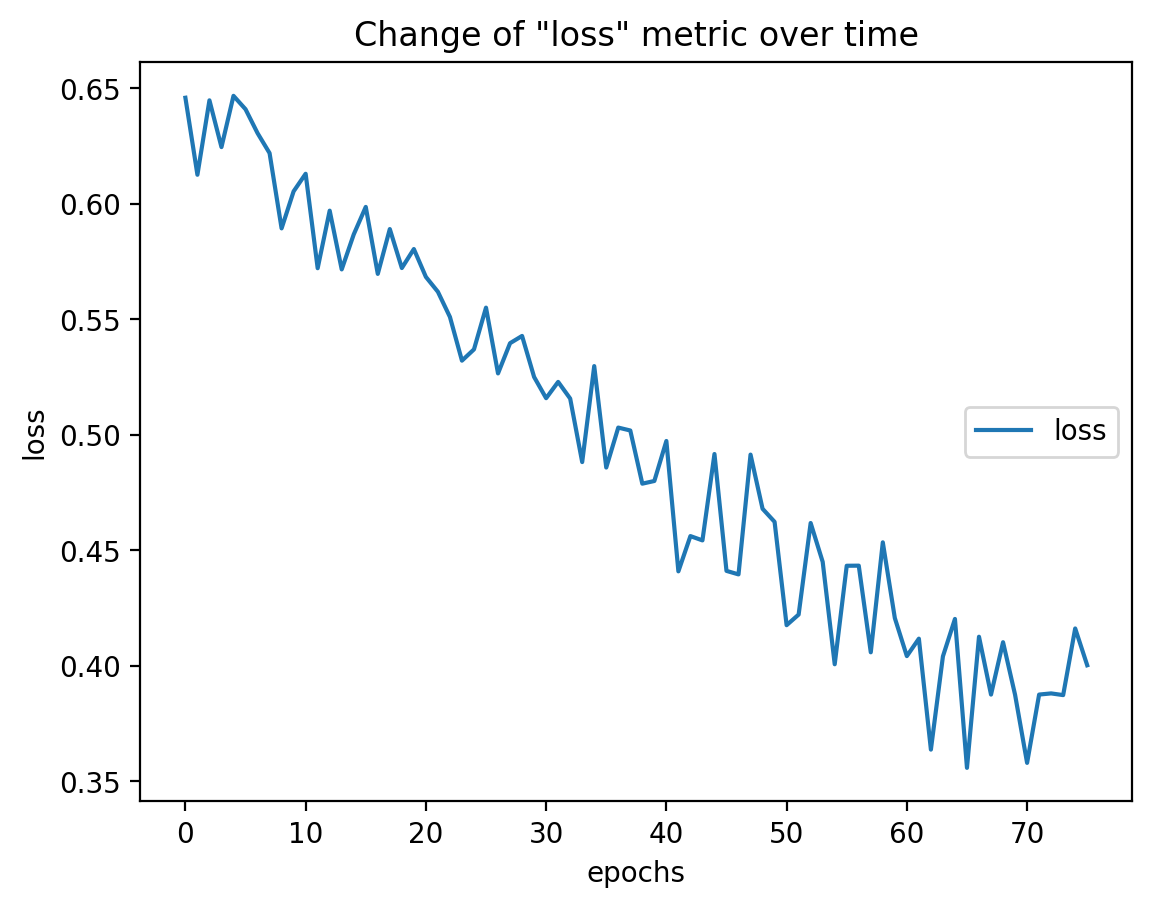

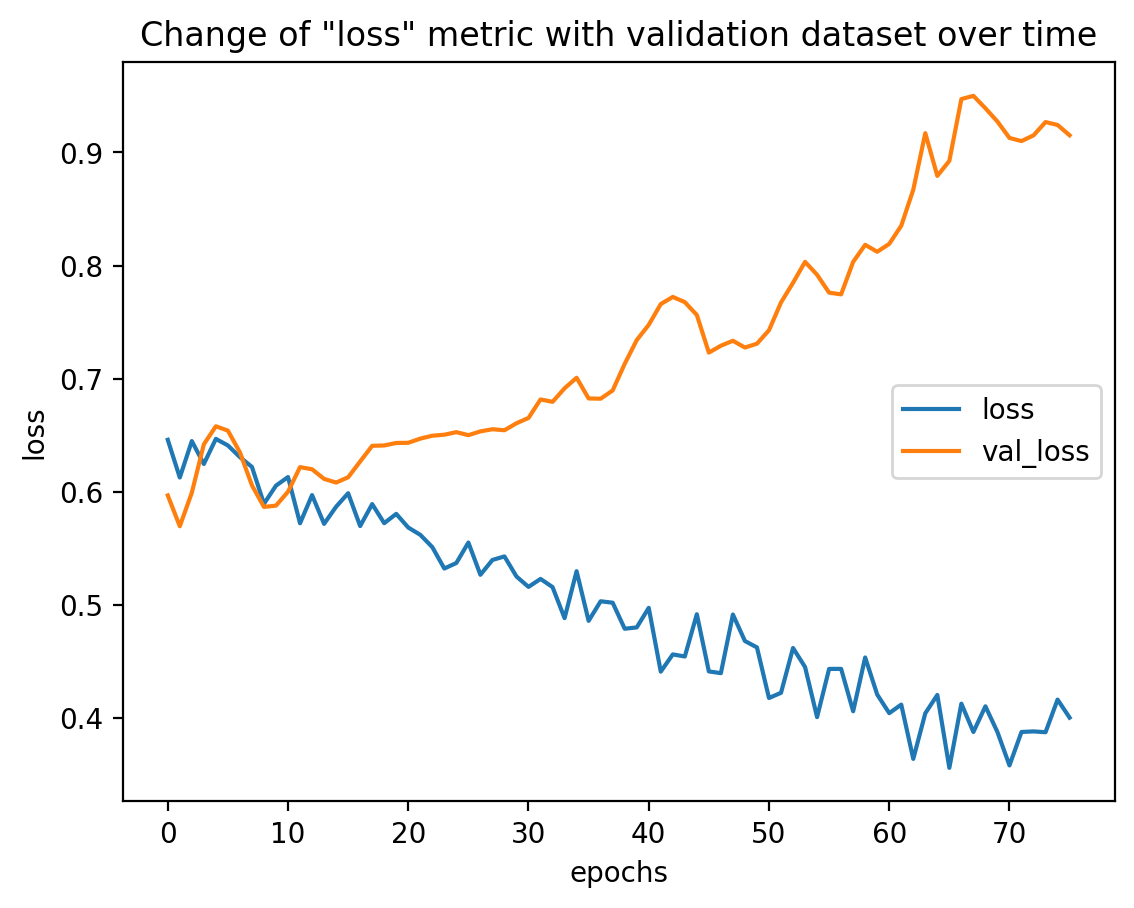

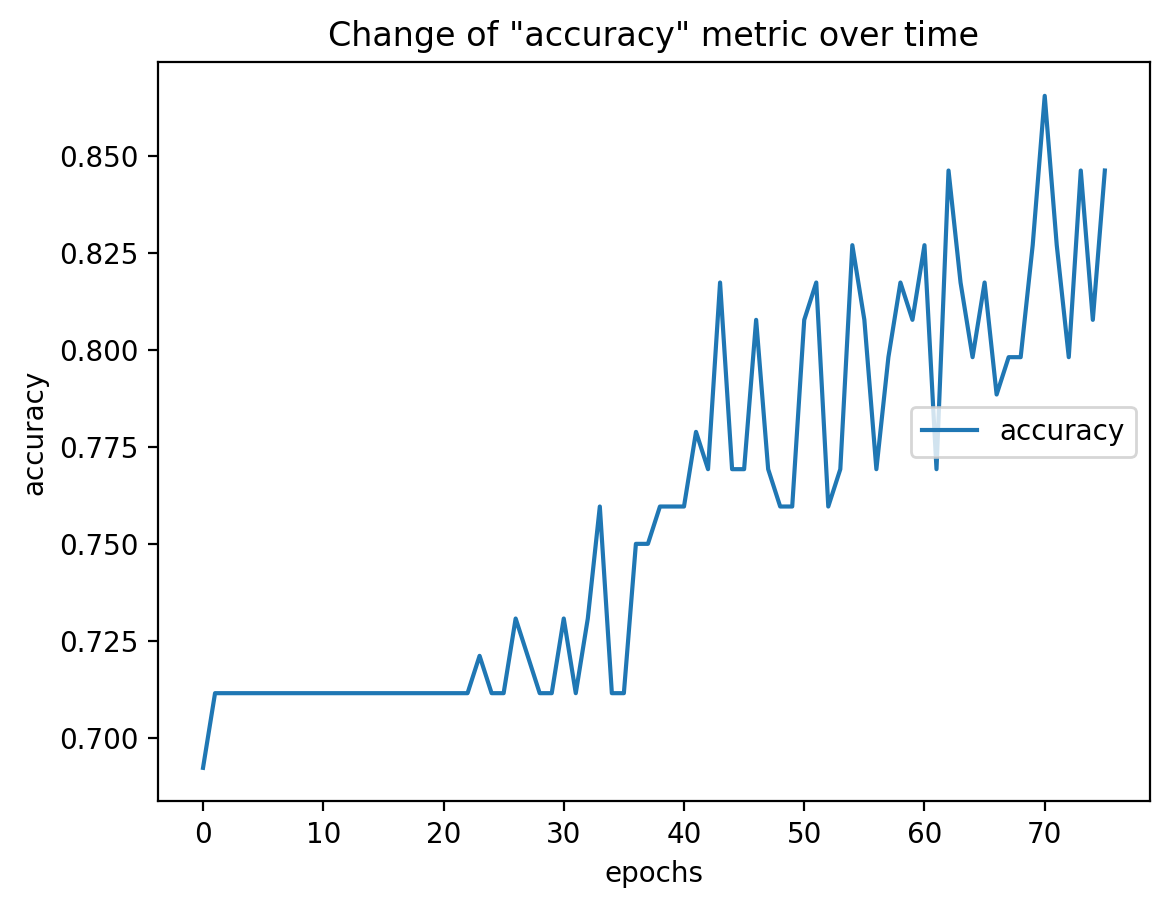

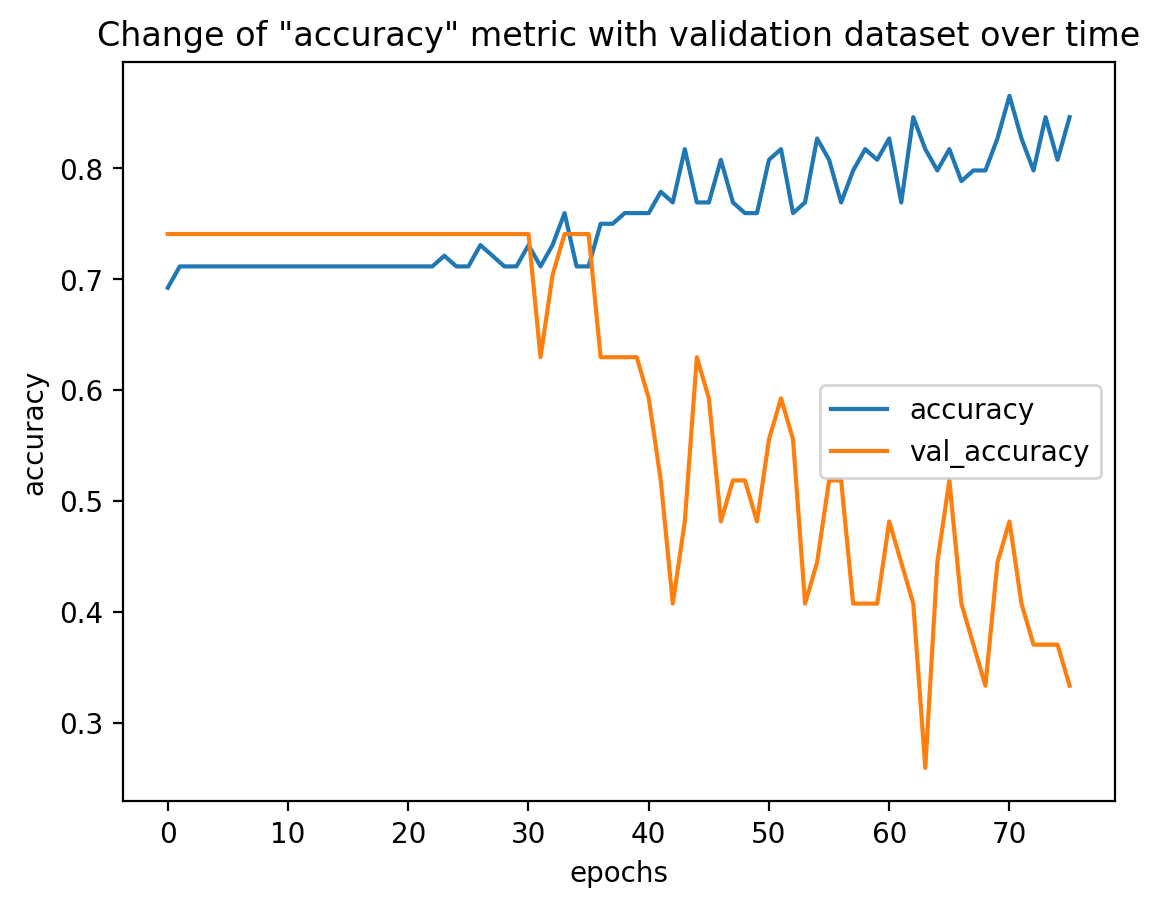

In [113]:
def plot_metric(metric: str, withVal: bool = False) -> None:
    # we can plot the results to see how our accuracy changed through each epoch
    fig = plt.figure()
    ax = fig.add_subplot(111)  # 1x1 subplot
    plt.xlabel("epochs")
    plt.ylabel(metric)

    ax.plot(results.history[metric], label=metric)
    if withVal:
        plt.title(f'Change of "{str(metric)}" metric with validation dataset over time')
        ax.plot(results.history["val_" + str(metric)], label="val_" + str(metric))
    else:
        plt.title(f'Change of "{metric}" metric over time')
    # plt.ylim(-1.5, 2.0)
    plt.legend(loc="center right")

    plt.show(block=False)


# list all data in history
for name in metric_names:
    plot_metric(name)
    if withVal:
        plot_metric(name, withVal)

#### <span style="color: royalblue;">c) </span> Test the model on data that is has not seen before


In [114]:
# predicting on data it does not know
# predictions = model.predict_classes(x_test) # classes
predictions = np.argmax(model.predict(testData, verbose=0), axis=-1)

# Output prediction probabilities
# predictions_prob = model.predict(x_test) # says how shure it is about its decision
# print(f'Probability that patient has metastasis is: {predictions_prob}')

# we have the answers because we have the y_test vector
conf_mat = confusion_matrix(y_test, predictions)
# [[True Negative, False Negative],
# [False Positive, True Positive]]

confusion = {
    "TruePositive": conf_mat[1][1],
    "TrueNegative": conf_mat[0][0],
    "FalsePositive": conf_mat[1][0],
    "FalseNegative": conf_mat[0][1],
}
accuracy = scores[1]
accuracy = round(accuracy * 100, 2)

#### <span style="color: royalblue;">d) </span> Print the confusion matrix values



Confusion Matrix:
	---------------------------------
	|	0	|	20	| 
	---------------------------------
	|	0	|	7	|
	---------------------------------

TruePositive	:	0
TrueNegative	:	7
FalsePositive	:	20
FalseNegative	:	0


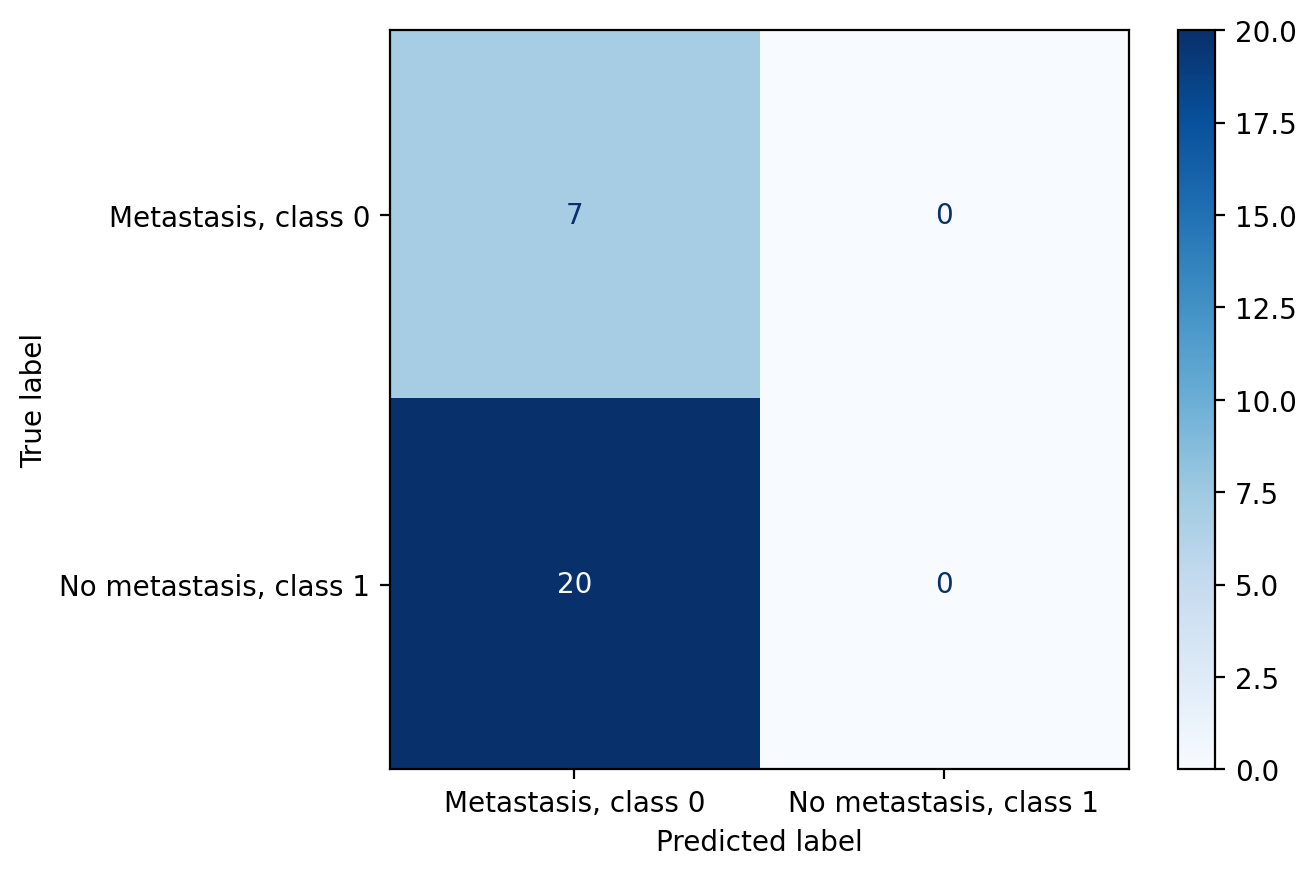

In [115]:
def printDict(obj: dict[str, int] = "") -> None:
    if isinstance(obj, dict):
        for k, v in obj.items():
            if hasattr(v, "__iter__"):
                print(k)
                printDict(v)
            else:
                print("%s\t:\t%s" % (k, v))
    elif isinstance(obj, list):
        for v in obj:
            if hasattr(v, "__iter__"):
                printDict(v)
            else:
                print(v)
    else:
        print(obj)


separator = "\t---------------------------------\n"
matrixConfusion = f'\nConfusion Matrix:\n{separator}\t|\t{confusion["TruePositive"]}\t|\t{confusion["FalsePositive"]}\t| \n{separator}\t|\t{confusion["FalseNegative"]}\t|\t{confusion["TrueNegative"]}\t|\n{separator}'
print(matrixConfusion)
printDict(confusion)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=TARGET_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### <span style="color: royalblue;">e) </span> Print the Classification Report

1. **Accuracy:**

- Accuracy in classification problems is the **number of correct predictions** made by the model divided by the **total number of predictions**.
- Accuracy is useful when the target classes are well balanced, i.e. have approximately the same number of elements.
- Accuracy is **not** a good choice for **unbalanced** classes!
- Imagine we had 99 images of dogs and 1 image of a cat. If our model was simply a line that always predicted **dogs**, we would get 99% accuracy! In this situation we'll want to understand recall and precision.

2. **Precision:**

- The ability of a classification model to identify only the relevant data points.
- Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives.

3. **Recall:**

- The ability of a model to find all relevant cases within a data set.
- The precise definition of recall is the number of true positives divided by the number of true positives plus the number of false negatives.

4. **Trade-offs between recall and precision:**

- There is often a trade-off between recall and precision.
- While recall expresses the ability to find all relevant instances in a data set, precision expresses the proportion of data points that our model said were relevant that were actually relevant.

5. **F1 score:**

- In cases where we want to find an optimal mix of precision and recall, we can combine the two metrics using what is called the F1 score.
- The F1 score is the harmonic mean of precision and recall taking into account both metrics in the following equation:
  $$ F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$
- We use the harmonic mean instead of a simple average because it penalises extreme values.
- A classifier with a precision of 1.0 and a recall of 0.0 has a simple average of 0.5 but an F1 score of 0.

6. **Support:**

- Support is how many samples are in each class.


In [116]:
# here we are not using the categorical values and not one hot encoded because the predictions have the original format
report = classification_report(y_test, predictions, target_names=TARGET_NAMES)

print(report)

                        precision    recall  f1-score   support

   Metastasis, class 0       0.26      1.00      0.41         7
No metastasis, class 1       0.00      0.00      0.00        20

              accuracy                           0.26        27
             macro avg       0.13      0.50      0.21        27
          weighted avg       0.07      0.26      0.11        27



d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## <span style="color: yellowgreen;">9. </span> Backup or restore the trained model

#### <span style="color: royalblue;">a) </span> Save the model


In [117]:
# save the model
model.save("../models/cnnModel.h5")

#### <span style="color: royalblue;">b) </span> Load the model and use it to predict classes of scaled test data


In [118]:
# load the model
# from keras.models import load_model
# newModel = load_model('./models/cnnModel.h5')

# use the loaded model to predict classes
# x_test is already after scaling!
# newModel.predict_classes(scaled_X_train)